# Text Classification: GOOD VS JUNK

## Introduction

**Notebook summary**: After exploring and visualizing different cross sections of the data, we build two classifiers to determine whether a block of text is syntactically correct or junk text. We compare a baseline Naive Bayes model and a Stochastic Gradient Descent model and prefer the performance of the Naive Bayes model for a test submission. <br><br>
**Methodology**: 

1.   Feature engineering based on text features
2.   Count Vectorizer
3. TF-IDF Transformer
4. SMOTE for class imbalance
5. Naive Bayes or SGD Classifier
6. Evaluation with F1 Score, Precision and ROC Curve
**Main Assumptions**: 1. Data is representative of population. 2. All text will have at least one character. <br><br>
**Next Steps**: The next steps for this project would be to implement different ways to tokenize the text such as using Word2Vec or BERT embeddings, and compare the scores given by each method. Afterwords, we would work on hyperparameter tuning with wider parameter ranges, adding the code to the platform pipeline and user testing to ensure the model is performing to spec.

In [86]:
# If additional packages are needed but are not installed by default, uncomment the last two lines of this cell
# and replace <package list> with a list of additional packages.
# This will ensure the notebook has all the dependencies and works everywhere

#import sys
#!{sys.executable} -m pip install <package list>

In [87]:
# Libraries
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline, make_pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import f1_score, precision_score, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from collections import Counter
import seaborn as sns

pd.set_option("display.max_columns", 101)
pd.set_option('display.max_colwidth', 100)

## Data Description

Column | Description
:---|:---
`text` | Text which needs to be classified
`label`  | Label ( 1 = GOOD, 0 = BAD)

In [88]:
# The information dataset for the training set is already loaded below
data = pd.read_csv('train.csv')
data.head()

,text,label
0,"Unfortunately, I did receive credible reports of calls that were not properly investigated.",1
1,534.27 48.21 500.00 500.00 .00 299.19 600.00 .00,0
2,"the rdi rm citizens, or of eag oati citizen, or oe Any in owning, C. gu t;",0
3,"Objectives: Improved self-esteem, new skills learned and collaboration with contemporary and tra...",1
4,"""Easement"" means an interest in land owned by another that entitles the easement holder to a spe...",1


Shape of data: (7265, 2)
------------------------------------------------------------------------------
General statistics: 
             label
count  7265.000000
mean      0.414040
std       0.492589
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
------------------------------------------------------------------------------
Null values: 
text     0
label    0
dtype: int64
------------------------------------------------------------------------------
Distinct categories: 



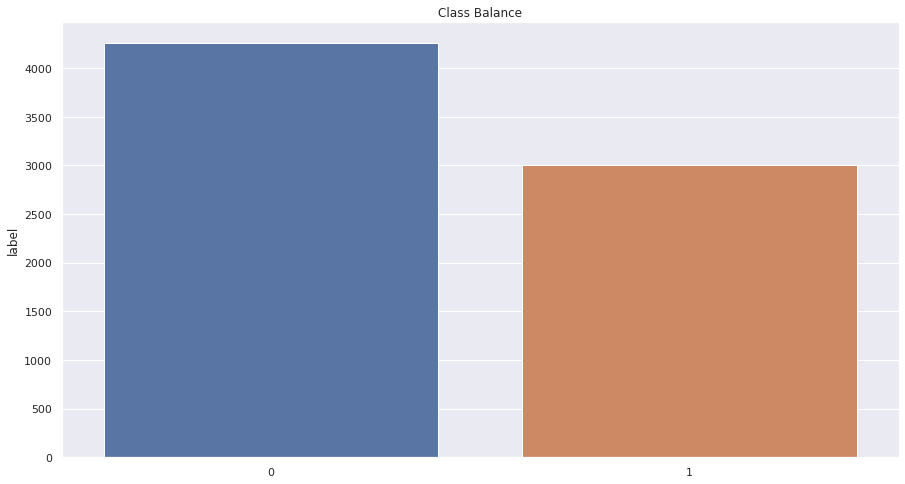

In [89]:
#Data exploration. Looks relatively evenly distributed amongst groups.

print("Shape of data: " + str(data.shape))
print("------------------------------------------------------------------------------")
print("General statistics: ")
print(data.describe())
print("------------------------------------------------------------------------------")
print("Null values: \n" + str(data.isna().sum()))
print("------------------------------------------------------------------------------")
print("Distinct categories: \n")
sns.barplot(x=data['label'].value_counts().index, y=data['label'].value_counts()).set(title='Class Balance');

## Feature Engineering

Here we transform the text to numerical representations so that it is ready to be inputted to the classifiers in the ML section below. We use the CountVectorizer and TF-IDF transformer modules as baselines recommended from SciKitLearn documentation but recognize that more advanced methods using transformers would likely perform better. Afterwords, we consider new features such as class balancing with SMOTE that would improve the F1 score.

In [90]:
#Before preprocessing
data.head(3)

,text,label
0,"Unfortunately, I did receive credible reports of calls that were not properly investigated.",1
1,534.27 48.21 500.00 500.00 .00 299.19 600.00 .00,0
2,"the rdi rm citizens, or of eag oati citizen, or oe Any in owning, C. gu t;",0


In [91]:
#Clean text and add features
data['text'] = data['text'].apply(lambda x: x.lower())

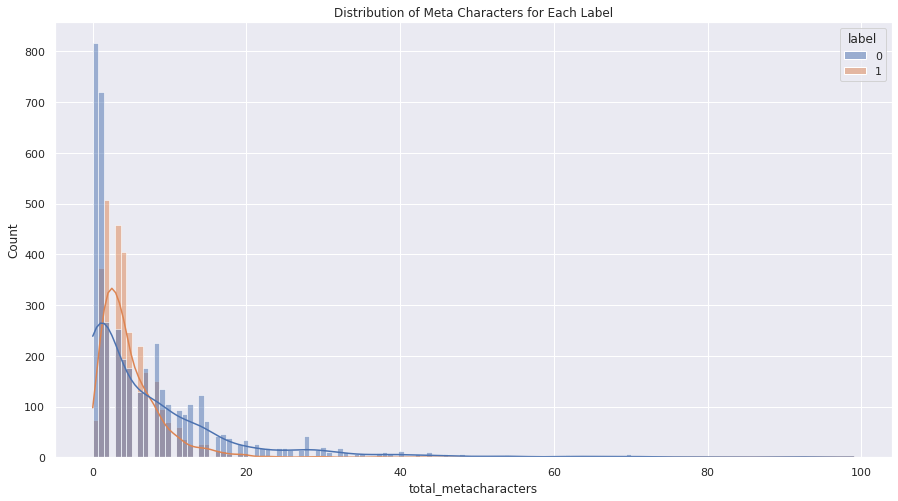

In [92]:
#New feature: count of meta characters like punctuation marks. 
#Idea behind this: the more meta characters, the more likely for it to be label=0 in longer strings
sns.set(rc = {'figure.figsize':(15,8)})

data['total_metacharacters'] = data['text'].apply(lambda x: len( re.findall("[^\w\s]", x)))

sns.histplot(data=data, x='total_metacharacters', hue = 'label', kde=True).set(title='Distribution of Meta Characters for Each Label');


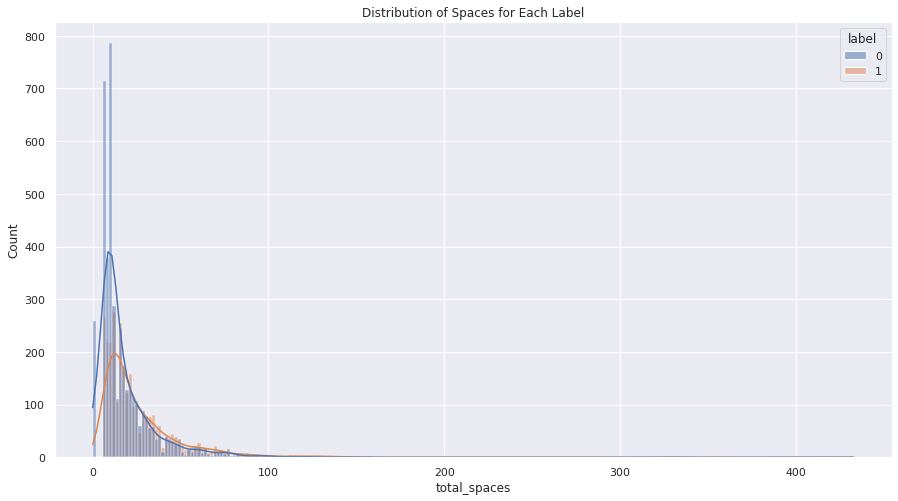

In [93]:
#New feature: Total number of spaces
#Idea behind this: from observing the training data, junk text appears to include more spaces

data['total_spaces'] = data['text'].apply(lambda x: len( re.findall("[\s]", x)))

sns.histplot(data=data, x='total_spaces', hue = 'label', kde=True).set(title='Distribution of Spaces for Each Label');


In [94]:
#After preprocessing
data.head(3)

,text,label,total_metacharacters,total_spaces
0,"unfortunately, i did receive credible reports of calls that were not properly investigated.",1,2,12
1,534.27 48.21 500.00 500.00 .00 299.19 600.00 .00,0,8,7
2,"the rdi rm citizens, or of eag oati citizen, or oe any in owning, c. gu t;",0,5,16


In [95]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(data[['text', 'total_metacharacters', 'total_spaces']], 
                                                    data['label'], test_size=0.33, random_state=42)

#Shapes of each split for validation
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((4867, 3), (2398, 3), (4867,), (2398,))

In [96]:
#Tokenizing words using Bag of Words and TFIDF
#Count Vectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.text)

#TFIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)


In [97]:
#Balance classes using SMOTE

#For Training Data: 
print("Rebalancing training data:")
# summarize class distribution
print("Classes before SMOTE: ")
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample_train = SMOTE(random_state=0)
X_train2, y_train2 = oversample_train.fit_resample(X_train_tfidf, y_train)
# summarize the new class distribution
print("Classes after SMOTE: ")
counter = Counter(y_train2)
print(counter)


Rebalancing training data:
Classes before SMOTE: 
Counter({0: 2811, 1: 2056})
Classes after SMOTE: 
Counter({0: 2811, 1: 2811})


## Machine Learning

Build a model that can predict the label.
- **The model's performance will be evaluated on the basis of F1 Score.**

### Baseline Model: Naive Bayes

Here we consider Naive Bayes as our baseline model since it is a fast and simple algorithm that does not require too much training data. We consider the Bernoulli version since we are working with binary labels.

In [98]:
#Sanity test before implementing Pipeline function

#Train model
clf = BernoulliNB().fit(X_train_tfidf, y_train)

#Create and transform data
docs_new = ['This is a correct sentence', '123 | %55 ok']
X_new_counts = count_vect.transform(docs_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

#Predict using classifier
predicted = clf.predict(X_new_tfidf)
for doc, category in zip(docs_new, predicted):
    print('%r => %s' % (doc, category))

'This is a correct sentence' => 0
'123 | %55 ok' => 0


In [99]:
#Pipeline method to streamline feature engineering and training

text_clf1 = imbpipeline( steps=[
    ['cleaning',
        ColumnTransformer([
        ('cat',make_pipeline( 
            CountVectorizer(),
            TfidfTransformer()), 'text')])
    ],
    ['smote', SMOTE(random_state=0)],
    ['clf1', BernoulliNB()],
])

#Fit and transform data
text_clf1.fit(X_train, y_train)

Pipeline(steps=[('cleaning',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('countvectorizer',
                                                                   CountVectorizer()),
                                                                  ('tfidftransformer',
                                                                   TfidfTransformer())]),
                                                  'text')])),
                ('smote', SMOTE(random_state=0)), ['clf1', BernoulliNB()]])

In [100]:
#Use Grid Search to identify the best hyperparameters

parameters1 = {
    'clf1__alpha': (1e-2, 1e-3),
}

gs_clf1 = GridSearchCV(text_clf1, parameters1, cv=5, n_jobs=-1)
gs_clf1 = gs_clf1.fit(X_train, y_train)

In [101]:
#Predict on test split and get accuracy
predicted1 = gs_clf1.predict(X_test)
acc1 = np.mean(predicted1 == y_test)
f11 = f1_score(y_test, predicted1, average='macro')
precision1 = precision_score(y_test, predicted1, average='macro')

print("Accuracy: " + str(acc1))
print("F1 Score: " + str(f11))

Accuracy: 0.9057547956630525
F1 Score: 0.9014712373854721


In [102]:
#Additional metrics for analysis

print(classification_report(y_test, predicted1, target_names = ['Junk', 'Good']))

              precision    recall  f1-score   support

        Junk       0.92      0.92      0.92      1446
        Good       0.88      0.88      0.88       952

    accuracy                           0.91      2398
   macro avg       0.90      0.90      0.90      2398
weighted avg       0.91      0.91      0.91      2398



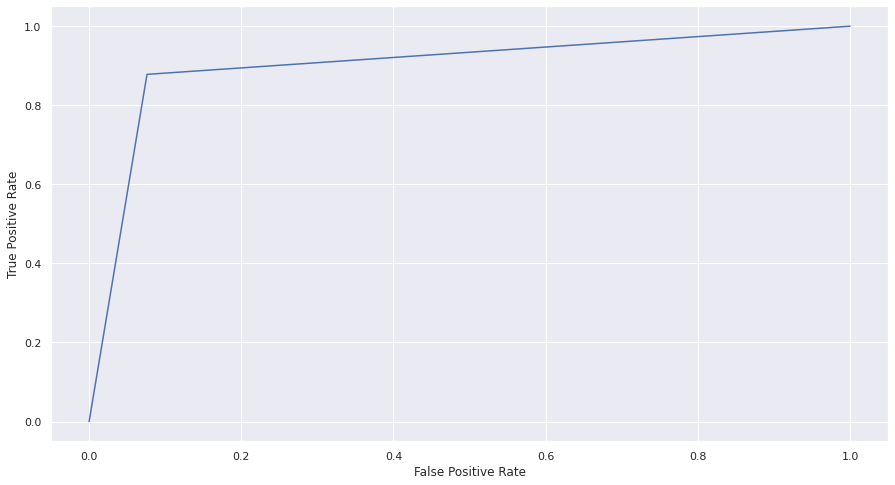

In [103]:
#Visualize performance with ROC Curve

fpr, tpr, _ = roc_curve(y_test, predicted1, pos_label=gs_clf1.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

### Stochastic Gradient Descent Model

Although 90% is not a bad score for this use case, we have the opportunity to test more developed models that scikitlearn documentation considers better performing than Naive Bayes. They consider the SGD model one of the best algorithms for document classification, which is why we test this model below. 

In [104]:
#Pipeline method to streamline feature engineering and training
text_clf2 = imbpipeline( steps=[
    ['cleaning2',
        ColumnTransformer([
        ('cat2',make_pipeline( 
            CountVectorizer(),
            TfidfTransformer()), 'text')])
    ],
    ['smote', SMOTE(random_state=0)],
    ['clf2', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)],
])

#Fit and transform data
text_clf2.fit(X_train, y_train)

#Run Grid Search to identify the best hyperparameters
parameters2 = {
    'clf2__alpha': (1e-2, 1e-3),
}

gs_clf2 = GridSearchCV(text_clf2, parameters2, cv=5, n_jobs=-1)
gs_clf2 = gs_clf2.fit(X_train, y_train)

#Predict on test split and get accuracy
predicted2 = gs_clf2.predict(X_test)
acc2 = np.mean(predicted2 == y_test)
f12 = f1_score(y_test, predicted2, average='macro')
precision2 = precision_score(y_test, predicted2, average='macro')

print("Accuracy: " + str(acc2))
print("F1 Score: " + str(f12))

Accuracy: 0.8603002502085071
F1 Score: 0.8573475519939255


In [105]:
#Additional metrics for analysis

print(classification_report(y_test, predicted2, target_names = ['Junk', 'Good']))

              precision    recall  f1-score   support

        Junk       0.93      0.83      0.88      1446
        Good       0.78      0.90      0.84       952

    accuracy                           0.86      2398
   macro avg       0.85      0.87      0.86      2398
weighted avg       0.87      0.86      0.86      2398



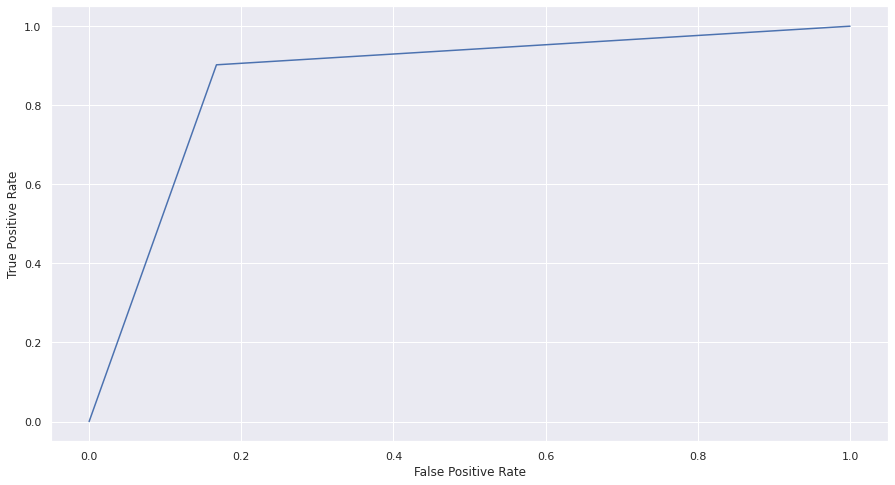

In [106]:
#Visualize performance with ROC Curve

fpr, tpr, _ = roc_curve(y_test, predicted2, pos_label=gs_clf2.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Evaluation

We find that the Naive Bayes model has a higher F1 score than the SGD model. In this use case **high precision is more important** since we would not want to misclassify good text. The **Naive Bayes model also outperforms SGD for this metric while being faster than the SGD model**, and so we would move forward with the Naive Bayes model. 

In [107]:
#Table of F1 Scores

metrics = ['Naive Bayes', 'SGD Model']
scores = {'F1': [f11,f12], 'Precision': [precision1, precision2], 'Accuracy': [acc1, acc2], 'Metric': metrics}

pd.DataFrame.from_dict(scores).set_index('Metric')

,F1,Precision,Accuracy
Metric,,,
Naive Bayes,0.901471,0.901916,0.905755
SGD Model,0.857348,0.854248,0.860300


> #### Task:
- **Submit the predictions on the test dataset using your optimized model** <br/>
    Submit a CSV file with a header row plus each of the test entries, each on its own line. 

The file (`submissions.csv`) should have exactly 1 column:

Column | Description
:---|:---
`label`  | Label

In [110]:
test = pd.read_csv('test.csv')
test.head()

,text
0,The requirement for planning commission hearings is to provide an opportunity for broad public i...
1,2.14 2.14 61.53 42.44 18.04 1.05 23.40 11.43 3.61 8.36 0.00 12.93 12.93 0.00 100%
2,D> x 3S 2 2 2 9 2 2 6
3,"If retentions are withheld, we require formal notification of completion and acceptance by owner..."
4,"""Duplex"" means a structure or use on one (1) lot involving two (2) attached common"


In [116]:
#Evaluate test set
test_df = test
test_df['total_metacharacters'] = test_df['text'].apply(lambda x: len( re.findall("[^\w\s]", x)))
test_df['total_spaces'] = test_df['text'].apply(lambda x: len( re.findall("[\s]", x)))

submission_df = pd.DataFrame.from_dict({'label':gs_clf2.predict(test_df)})

In [118]:
#Submission
submission_df.to_csv('submissions.csv', index=False)

## References


*   https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568#:~:text=Linear%20Support%20Vector%20Machine%20is,the%20best%20text%20classification%20algorithms. 
*   https://scikit-learn.org/stable/modules/naive_bayes.html#bernoulli-naive-bayes
*   https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
*   https://arxiv.org/pdf/1106.1813.pdf
*   https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7



##Thank you!